In [15]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tabpfn import TabPFNClassifier

normal_path = "transients/S01/1/Normal/q_data"
relay_path  = "transients/S01/1/Relay/q_data"

with h5py.File("datasets/transients_cleaned_padded.h5", "r") as f:
    normal_group = f[normal_path]
    relay_group  = f[relay_path]

    n_norm = normal_group["0"].shape[0]
    n_relay = relay_group["0"].shape[0]

    dataset_normal = np.zeros((49666, n_norm))
    dataset_relay  = np.zeros((49666, n_relay))

    for i in range(49666):
        try:
            dataset_normal[i] = normal_group[str(i)][:]
        except KeyError:
            continue

    for i in range(49666):
        try:
            dataset_relay[i] = relay_group[str(i)][:]
        except KeyError:
            continue

scalerMinMax = MinMaxScaler()
scalerStandard = StandardScaler()

X_train_normal = dataset_normal[:700]
X_train_relay  = dataset_relay[:700]
X_train = np.vstack((X_train_normal, X_train_relay))
X_test_normal         = dataset_normal[47500:]
X_test_relay          = dataset_relay[47500:]

scalerMinMax.fit(X_train)
X_train_scaled_minmax       = scalerMinMax.transform(X_train)
X_test_norm_scaled_minmax   = scalerMinMax.transform(X_test_normal)
X_test_relay_scaled_minmax  = scalerMinMax.transform(X_test_relay)

scalerStandard.fit(X_train)
X_train_scaled_standard        = scalerStandard.transform(X_train)
X_test_norm_scaled_standard    = scalerStandard.transform(X_test_normal)
X_test_relay_scaled_standard   = scalerStandard.transform(X_test_relay)

X_test_combined = np.vstack((X_test_normal, X_test_relay))
X_test_combined_scaled_minmax = np.vstack((X_test_norm_scaled_minmax, X_test_relay_scaled_minmax))
X_test_combined_scaled_standard = np.vstack((X_test_norm_scaled_standard, X_test_relay_scaled_standard))

y_train = np.array([0] * len(X_train_normal) + [1] * len(X_train_relay))
y_true = np.array([0] * len(X_test_normal) + [1] * len(X_test_relay))


Classification Report:
               precision    recall  f1-score   support

      Normal       0.80      0.88      0.84      2166
       Relay       0.87      0.78      0.82      2166

    accuracy                           0.83      4332
   macro avg       0.83      0.83      0.83      4332
weighted avg       0.83      0.83      0.83      4332



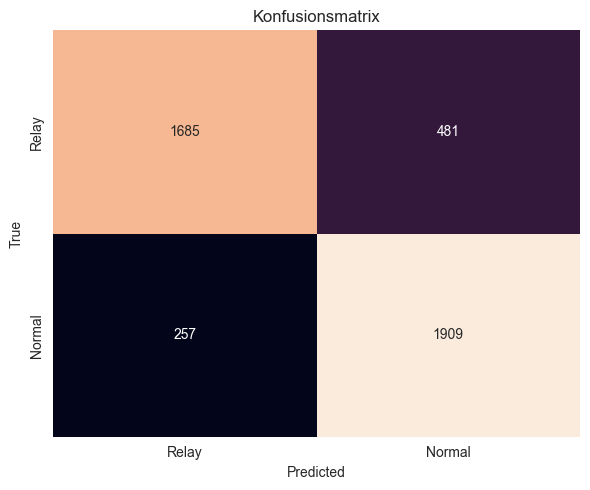

In [16]:
clf = TabPFNClassifier(ignore_pretraining_limits=True)
clf.fit(X_train, y_train)

# pyod.predict: 0 = inlier, 1 = outlier
y_pred = clf.predict(X_test_combined)

# cm und report
cm = confusion_matrix(y_true, y_pred, labels=[1,0])
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["Normal","Relay"]))

# plot
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=["Relay","Normal"],
            yticklabels=["Relay","Normal"],
            cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Konfusionsmatrix")
plt.tight_layout()
plt.show()